# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# RC Filter

## Code

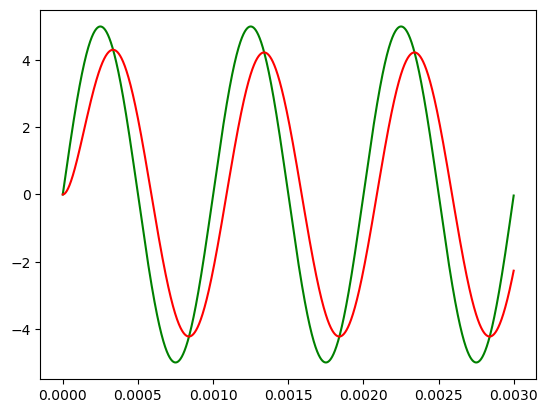

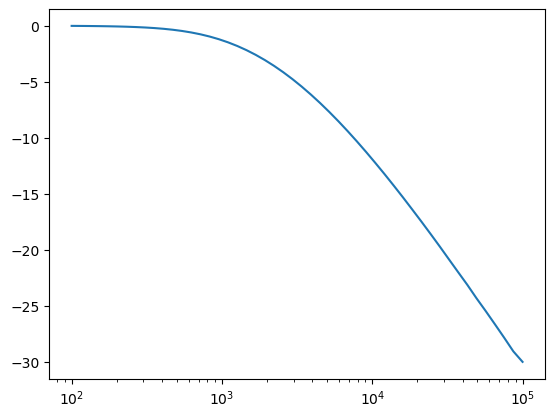

In [3]:
R = 1e5 # 100 kOhm
C = 1e-9 # 1 nanoFarad
V0 = 5
freq = 1000 # hurtz
dt = 1e-7 # 1 microsecond
simLength = 3e-3 # 1 millisecond




def getBVector(V0, omega, t, C, dt, Vb):
    Vi = V0*np.sin(omega*t)
    Ieq = -C*Vb/dt
    return np.array([0, Ieq, Vi]).T

def simulateFilter(R, C, V0, freq, dt, simLength):
    Va = 0
    Vb = 0
    Ivi = 0
    omega = 2*3.14159*freq
    A = np.array([
        [-1/R, 1/R, 1],
        [1/R, -(1/R + C/dt), 0],
        [1, 0, 0]
    ])
    Ainv = np.linalg.inv(A)
    
    time = np.arange(0, simLength, dt)
    VaOverTime = np.zeros(len(time))
    VbOverTime = np.zeros(len(time))
    for i, t in enumerate(time):
        xVector = np.dot(Ainv, getBVector(V0, omega, t, C, dt, Vb))
        Va = xVector[0]
        Vb = xVector[1]
        Ivi = xVector[2]
        VaOverTime[i] = Va
        VbOverTime[i] = Vb
    return time, VaOverTime, VbOverTime

# Plot one frequency
time, Va, Vb = simulateFilter(R, C, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.show()

# Now plot many frequencies
minFreq = 2
maxFreq = 5
numFreqs = 50
freqs = np.logspace(minFreq, maxFreq, numFreqs)
decibels = np.zeros(numFreqs)
for i, f in enumerate(freqs):
    time, Va, Vb = simulateFilter(R, C, V0, f, dt, simLength)
    gain = np.max(Vb) / np.max(Va)
    decibels[i] = 20*np.log10(gain)

# Plot many frequencies
plt.xscale("log")
plt.plot(freqs, decibels)
plt.show()



## Analysis

### Choices of parameters
I started with the capacitance, resistance, voltage, and simulation length from Dr. Bocan's powerpoint slides, as I liked how her results looked and wanted to match those, but then I kept them because those are common values of resistors and capacitors that I have used in circuits labs, and the simulation length is enough to see a few cycles of the sine wave. For the graph of the single frequency I also used the frequency from the slides.

The voltage is irrelevant, as it just acts as an amplitude that gets multiplied by the sine and actually has no effect on how the circuit behaves, it's just kind of a scalar that floats outside every equation. I went with 5v because it's pretty standard.

The timestep I chose was because I needed a timestep that was small enough to sample points enough within the sine waves. The maximum frequency I used is 100kHz, so with a dt of 1e-6, that means that it will sample the sine wave 100 times each cycle, which is enough to clearly get the full shape of the sine wave. And at the lower frequencies like 1kHz it gets sampled tens of thousands of times so is very accurate there. If I wanted to be more rigorous and efficient, I should define the dt and simulation length as functions of frequency, so that at really high frequencies like MHz, the dt could be in the nanosecond scale, but the simulation length would be in the microsecond scale, and then you would achieve the same accuracy at all frequencies, but I didn't have time to implement this.

### Verification
The 1000KHz frequency example from the powerpoint slides I also ran in LTSpice myself to compare the results, and they match perfectly! ![RCFilterSim](RCFilterSim.png)

Then I made a bode plot in LTSpice using the AC sweep analysis tool, and the solid lined curve matches my result perfecly! ![RCFilterBode](RCFilterBodePlot.png)

Cutoff frequency is 1591, you can see that thats where it cuts off (-3db)

# Half-wave rectifier

## Code

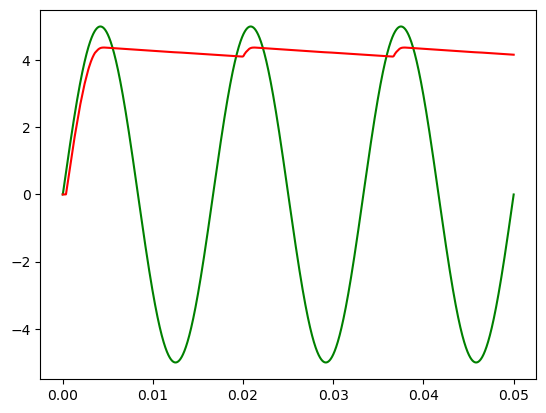

In [6]:
R = 1e3 # 1 kOhm
C = 470e-6 # 1 microFarad
V0 = 5
n = 1 # ideal diode
Vt = 0.026 # 26 millivolts
Is = 1e-12 # 5 nanoamp reverse saturation current
freq = 60 # hurtz
simLength = 50e-3 # milliseconds
dt = simLength/10000.0 # microseconds

def getAMatrix(dt, R, C, Vd):
    Gdeq = getGDEQ(Vd)
    # Gdeq = 1 if Vi > 0.7 else 0
    A = np.array([
        [-Gdeq, Gdeq, 1],
        [Gdeq, -(Gdeq + 1/R + C/dt), 0],
        [1, 0, 0]
    ])
    return A

def getBVector(V0, freq, t, C, dt, Ivi, Vd, Vb):
    Vi = V0*np.sin(freq*2*3.1415926*t)
    Iceq = -C*Vb/dt
    Gdeq = getGDEQ(Vd)
    # Gdeq = 1 if Vi > 0.7 else 0
    Ideq = getDiodeCurrent(Vd) - Gdeq*(Vd)
    return np.array([Ideq, Iceq-Ideq, Vi]).T

def getGDEQ(Vd):
    return Is/(n*Vt)*np.exp(Vd/(n*Vt))

def getDiodeCurrent(Vd):
    return Is*(np.exp(Vd/(n*Vt))-1)

def simulateRectifier(R, C, V0, freq, dt, simLength):
    Vd = 0 # Initial guess
    Va = 0
    Vb = Va - Vd
    Ivi = 0
    Vas = [Va]
    Vbs = [Vb]
    t=0
    times = [t]
    while t < simLength:
        dynDt = dt
        while True:
            numAttempts = 0
            Vq = Vd
            VaGuess = Va
            VbGuess = Vb
            IviGuess = Ivi
            while numAttempts < 10:
                A = getAMatrix(dynDt, R, C, Vq)
                Ainv = np.linalg.inv(A)
                xVector = np.dot(Ainv, getBVector(V0, freq, t, C, dynDt, IviGuess, Vq, VbGuess))
                VaGuess = xVector[0]
                VbGuess = xVector[1]
                IviGuess = xVector[2]
                numAttempts += 1
                error = np.abs((VaGuess - VbGuess) - Vq)
                if error < 0.001:
                    break
                Vq = VaGuess-VbGuess
            if error < 0.001:
                Va = VaGuess
                Vb = VbGuess
                Ivi = IviGuess
                break
            dynDt *= 0.1
            if dynDt < dt/1000.0:
                print("ERROR CANT CONVERGE")
                return
        Vd = Va-Vb
        Vas.append(Va)
        Vbs.append(Vb)
        t += dynDt
        times.append(t)
    return times, Vas, Vbs

# Plot it
time, Va, Vb = simulateRectifier(R, C, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.show()

## Analysis

### Choices of parameters
#### Diode
I used the standard V_t of 26 millivolts, and n=1 for a perfectly ideal diode. And the standard leakage current of 1e-12 Amps. I got all these values from [Diode Constant Values](https://www.allaboutcircuits.com/textbook/semiconductors/chpt-3/introduction-to-diodes-and-rectifiers/#:~:text=It%20is%20commonly%20known%20as%20the%20diode%20equation%3A,At%20room%20temperature%2C%20this%20is%20about%2026%20millivolts.)

#### R, C, f
I didn't want to use the values Dr. Bocan head in the powerpoint slides because you can't see the effect of the filter capacitor as clearly using her parameters, so instead I used this source, [Halfwave Rectifier typical values](https://www.philadelphia.edu.jo/academics/fobeidat/uploads/Power%20Electronic%20Course/3%20Single%20Phase%20Uncontrolled%20Half-Wave%20Rectifiers.pdf), to see typical values of R, C, and f. But it had 120Hz for f so I changed it to 60Hz to match standard wall outlets, then I slightly modified R and C to be resistance and capacitance values that I have frequently used in circuits lab.

#### Voltage
As I said in the RC Filter analysis, the voltage isn't relevant and is just a scalar outside all the equations. 5v is pretty standard so went with that.

#### Timestep and Simulation length
I made the simulation length just long enough to see a few full cycles of the sine wave with the frequency that I chose, and then I made the timestep just small enough to get a high degree of accuracy. I defined it to be simLength/10000 so that there would be thousands of samples within each cycle of the sine wave.

### Verification
I built my circuit with the same parameters in LTSpice, and simulated it, and the results match my simulation perfectly! ![HalfwaveSim](HalfwaveSim.png)

### Changing R and C
Here I run the halfwave rectifier sim a few more times with different values of R and C:

#### Code

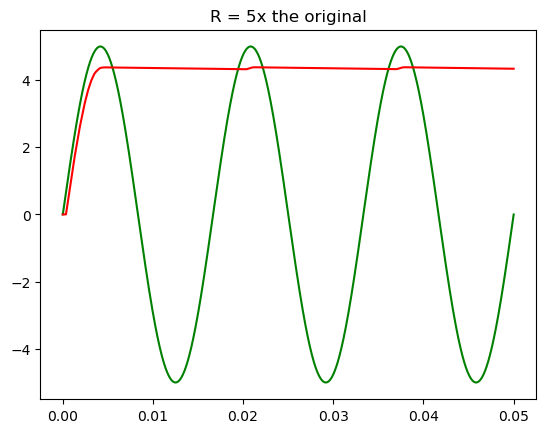

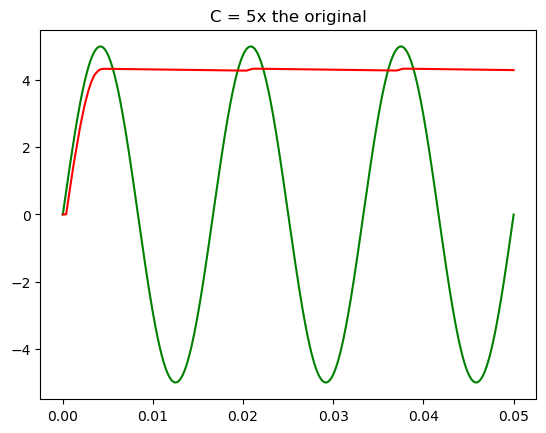

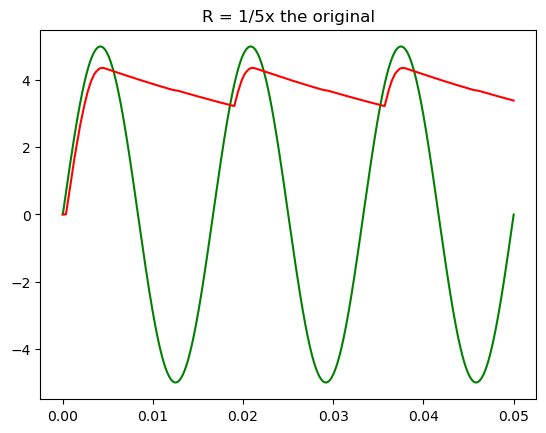

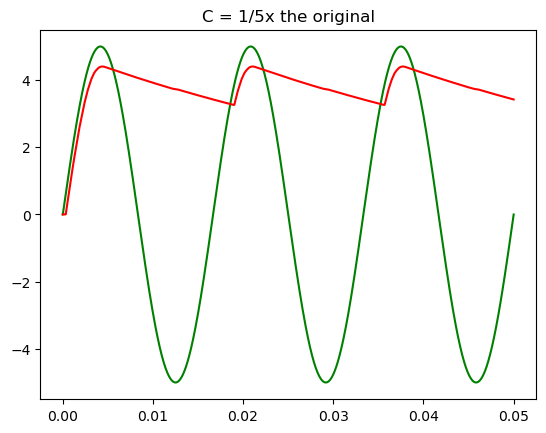

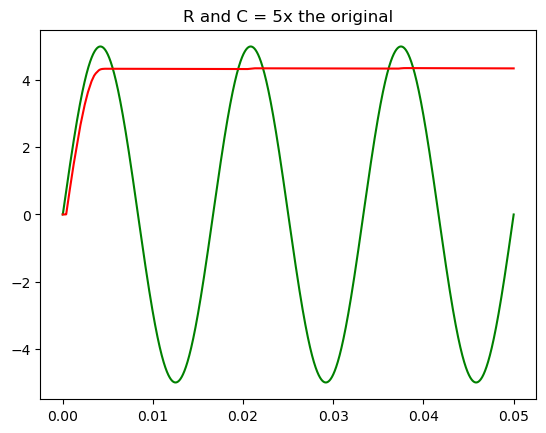

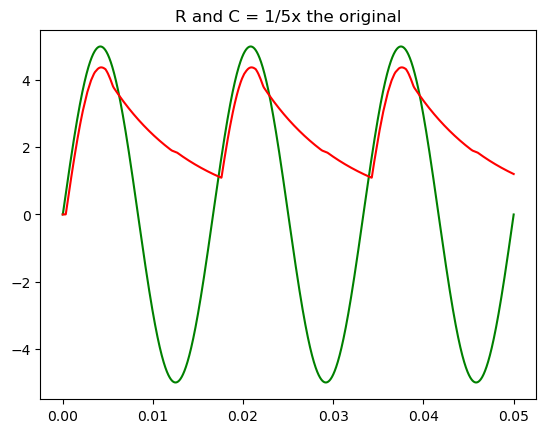

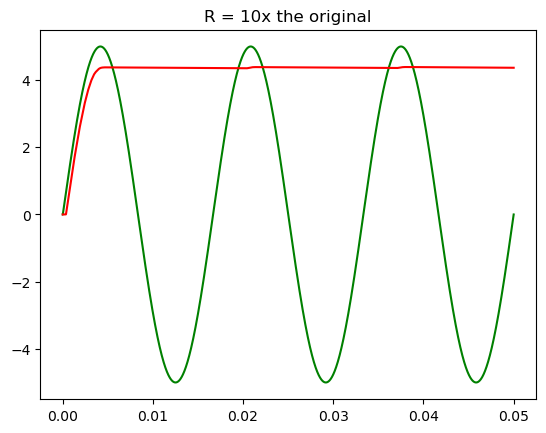

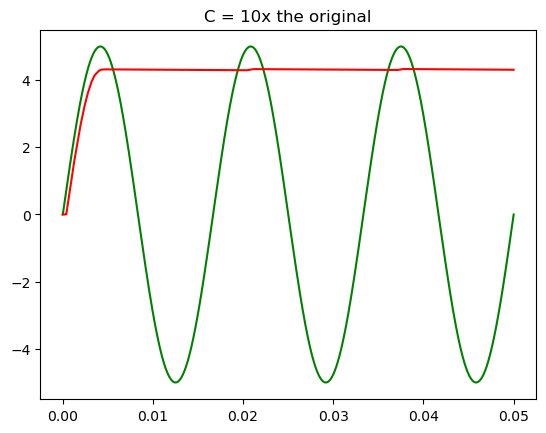

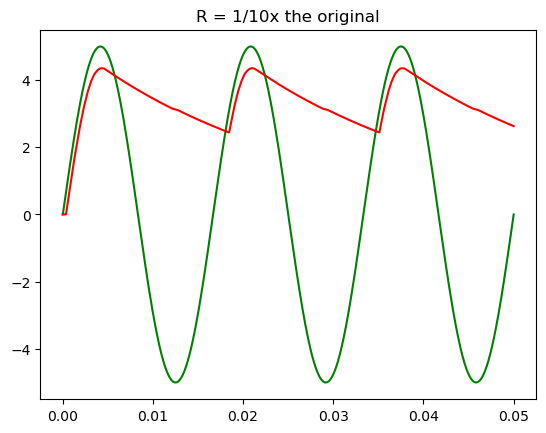

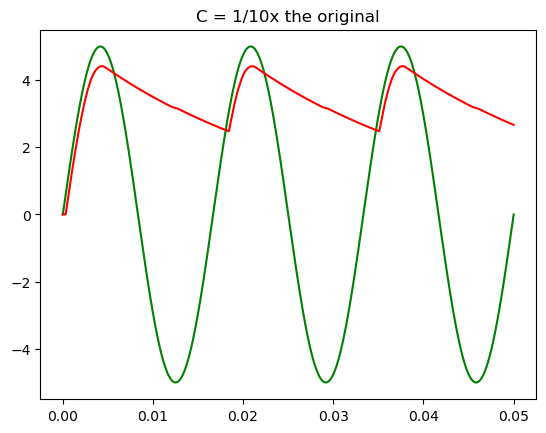

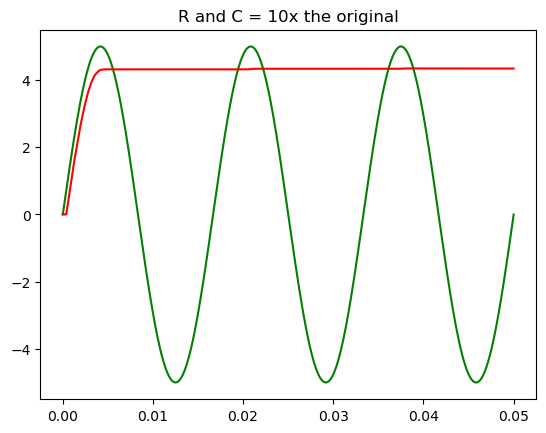

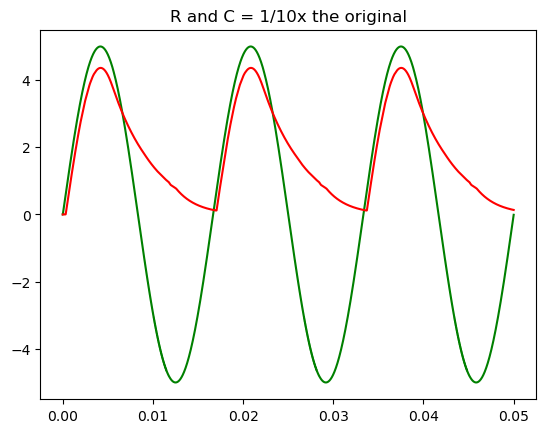

In [7]:
# Plot a few different sims with different R's and C's
time, Va, Vb = simulateRectifier(R*5, C, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R = 5x the original")
plt.show()

time, Va, Vb = simulateRectifier(R, C*5, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("C = 5x the original")
plt.show()

time, Va, Vb = simulateRectifier(R/5, C, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R = 1/5x the original")
plt.show()

time, Va, Vb = simulateRectifier(R, C/5, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("C = 1/5x the original")
plt.show()

time, Va, Vb = simulateRectifier(R*5, C*5, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R and C = 5x the original")
plt.show()

time, Va, Vb = simulateRectifier(R/5, C/5, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R and C = 1/5x the original")
plt.show()

time, Va, Vb = simulateRectifier(R*10, C, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R = 10x the original")
plt.show()

time, Va, Vb = simulateRectifier(R, C*10, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("C = 10x the original")
plt.show()

time, Va, Vb = simulateRectifier(R/10, C, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R = 1/10x the original")
plt.show()

time, Va, Vb = simulateRectifier(R, C/10, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("C = 1/10x the original")
plt.show()

time, Va, Vb = simulateRectifier(R*10, C*10, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R and C = 10x the original")
plt.show()

time, Va, Vb = simulateRectifier(R/10, C/10, V0, freq, dt, simLength)
plt.plot(time, Va, color="green")
plt.plot(time, Vb, color="red")
plt.title("R and C = 1/10x the original")
plt.show()

#### Analysis
We can see from these graphs that whenever you change R by some amount, and then in another run change C by the same amount, you get the same result. This shows that the behavior of the rectifier depends only on the time constant R\*C, and not R or C independently.

More importantly, we see that with higher time constants, there is less ripple in the output, because the RC part of the circuit has a higher time constant and takes more time to lose its voltage that it has built up, but with lower time constants, there is more ripple, because the RC part of the circuit has a lower time constant and can change its values more quickly.

### Timestep convergence vs no convergence

With a timestep of simLength/10000 it converges easily, i.e. it doesn't have to do the reset and go back and try again with a smaller timestep as often.

With a timestep of simLength/1000, it still converges, but needs to do the reset and go back and try again routine more often, resulting in a longer run time, as there are more failed attempts.

With a timestep of simLength/100, it won't converge at all using reasonable values for the timestep shrinkage limit. But if I let the timestep shrink very small compared to that of the original it will converge, but it takes much much longer to run because it has to go back and reset so many times with so many failed attempts that are just wasting time.

With a timestep of simLength/1_000000 it converges even easier, but the timestep is so small that now it starts to take longer to run because of needing to do so many steps.

So somewhat counterintuitively, there is a sweet spot of around simLength/10000 to make the code run the fastest and yet still very accurately. Because with much smaller timesteps its obviously too slow, but with much higher timesteps, it takes more failed attempts and resets before it can converge, which just eats up processor time with no positive effect.

So for the frequency and simLength parameters I was using, dt of simLength/10000 seems to be mostly optimal!

# Sources
[Diode Constant Values](https://www.allaboutcircuits.com/textbook/semiconductors/chpt-3/introduction-to-diodes-and-rectifiers/#:~:text=It%20is%20commonly%20known%20as%20the%20diode%20equation%3A,At%20room%20temperature%2C%20this%20is%20about%2026%20millivolts.)

[Halfwave Rectifier typical values](https://www.philadelphia.edu.jo/academics/fobeidat/uploads/Power%20Electronic%20Course/3%20Single%20Phase%20Uncontrolled%20Half-Wave%20Rectifiers.pdf)  
In this source, I got starting values for R, C, and f, then I changed f to 60Hz because our outlets have that, then I modified R and C to get a result I liked

[How I made Bode plot for verification](https://www.analog.com/en/resources/technical-articles/how-to-generate-a-bode-plot-with-ltspice.html)